#Data preperation for UNet

In [5]:
# Install required libraries if not available
!pip install netCDF4 numpy pandas torch torchvision

In [6]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Define file paths (update if needed)
train_file = "/content/drive/MyDrive/drought_data/processed/drought_train_normalized_imp.nc"
val_file = "/content/drive/MyDrive/drought_data/processed/drought_val_normalized_imp.nc"

# Load NetCDF datasets
train_dataset = nc.Dataset(train_file, mode='r')
val_dataset = nc.Dataset(val_file, mode='r')

# Print metadata
print(train_dataset)

# Extract time, latitude, longitude
time = train_dataset.variables['time'][:]
lat = train_dataset.variables['latitude'][:]
lon = train_dataset.variables['longitude'][:]

# Define meteorological variables
variables = ['z500', 't850', 'e', 'evavt', 'lai_lv', 'pev', 'swvl2', 'swvl3', 't2m', 'tp']

# Initialize arrays for data storage
train_data = np.zeros((len(time), len(lat), len(lon), len(variables)))  # (time, lat, lon, features)

# Extract data while maintaining spatial structure
for i, var in enumerate(variables):
    train_data[:, :, :, i] = train_dataset.variables[var][:]

# Handle missing values (replace NaNs with mean of variable)
for i in range(train_data.shape[-1]):
    var_data = train_data[:, :, :, i]
    var_data[np.isnan(var_data)] = np.nanmean(var_data)
    train_data[:, :, :, i] = var_data

# Normalize/Standardize data
#scalers = {}  # Store scalers for inverse transformation later
#for i in range(train_data.shape[-1]):
#    scaler = StandardScaler()
#    train_data[:, :, :, i] = scaler.fit_transform(train_data[:, :, :, i].reshape(-1, 1)).reshape(train_data[:, :, :, i].shape)
#    scalers[variables[i]] = scaler  # Save for later inverse transform

# Convert to Torch tensors for training
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)

print("Final dataset shape:", train_data_tensor.shape)  # Expected: (time, lat, lon, features)


<class 'netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    dimensions(sizes): time(2556), latitude(14), longitude(14)
    variables(dimensions): float32 z500(time, latitude, longitude), float64 t850(time, latitude, longitude), float32 e(time, latitude, longitude), float32 evavt(time, latitude, longitude), float32 lai_lv(time, latitude, longitude), float32 pev(time, latitude, longitude), float32 swvl2(time, latitude, longitude), float32 swvl3(time, latitude, longitude), float32 t2m(time, latitude, longitude), float32 tp(time, latitude, longitude), int32 time(time), float32 latitude(latitude), float32 longitude(longitude)
    groups: 
Final dataset shape: torch.Size([2556, 14, 14, 10])


In [7]:
# Load validation dataset
val_dataset = nc.Dataset(val_file, mode='r')

# Extract time, latitude, longitude
val_time = val_dataset.variables['time'][:]
val_lat = val_dataset.variables['latitude'][:]
val_lon = val_dataset.variables['longitude'][:]

# Initialize validation data storage
val_data = np.zeros((len(val_time), len(val_lat), len(val_lon), len(variables)))  # (time, lat, lon, features)

# Extract data while maintaining spatial structure
for i, var in enumerate(variables):
    val_data[:, :, :, i] = val_dataset.variables[var][:]

# Handle missing values in validation set (use mean of training data if missing)
for i in range(val_data.shape[-1]):
    var_data = val_data[:, :, :, i]
    var_data[np.isnan(var_data)] = np.nanmean(var_data)  # Fill NaNs with variable mean
    val_data[:, :, :, i] = var_data

# Normalize validation data using the SAME scalers from training
#for i in range(val_data.shape[-1]):
#    val_data[:, :, :, i] = scalers[variables[i]].transform(val_data[:, :, :, i].reshape(-1, 1)).reshape(val_data[:, :, :, i].shape)

# Convert to Torch tensor
val_data_tensor = torch.tensor(val_data, dtype=torch.float32)

print("Validation dataset shape:", val_data_tensor.shape)  # Expected: (time, lat, lon, features)


Validation dataset shape: torch.Size([1096, 14, 14, 10])


In [8]:
import torch

def create_sequences(data_tensor, input_length=60, output_length=44):
    """
    Creates sliding window sequences for forecasting.

    Args:
    - data_tensor: Tensor of shape (time, lat, lon, features)
    - input_length: Number of days used as input
    - output_length: Number of days to predict

    Returns:
    - X: Input tensor of shape (num_samples, input_length, lat, lon, features)
    - Y: Target tensor of shape (num_samples, output_length, lat, lon, features)
    """
    num_samples = data_tensor.shape[0] - (input_length + output_length)
    X = []
    Y = []

    for i in range(num_samples):
        X.append(data_tensor[i : i + input_length])  # 60 days input
        Y.append(data_tensor[i + input_length : i + input_length + output_length])  # Output days

    return torch.stack(X), torch.stack(Y)


# Generate sequences for different forecast horizons
X_train_44, Y_train_44 = create_sequences(train_data_tensor, input_length=60, output_length=44)
X_train_30, Y_train_30 = create_sequences(train_data_tensor, input_length=60, output_length=30)
X_train_14, Y_train_14 = create_sequences(train_data_tensor, input_length=60, output_length=14)

X_val_44, Y_val_44 = create_sequences(val_data_tensor, input_length=60, output_length=44)
X_val_30, Y_val_30 = create_sequences(val_data_tensor, input_length=60, output_length=30)
X_val_14, Y_val_14 = create_sequences(val_data_tensor, input_length=60, output_length=14)

# Print shapes to verify
print(f"Train 60→44: X={X_train_44.shape}, Y={Y_train_44.shape}")
print(f"Train 60→30: X={X_train_30.shape}, Y={Y_train_30.shape}")
print(f"Train 60→14: X={X_train_14.shape}, Y={Y_train_14.shape}")

print(f"Validation 60→44: X={X_val_44.shape}, Y={Y_val_44.shape}")
print(f"Validation 60→30: X={X_val_30.shape}, Y={Y_val_30.shape}")
print(f"Validation 60→14: X={X_val_14.shape}, Y={Y_val_14.shape}")


Train 60→44: X=torch.Size([2452, 60, 14, 14, 10]), Y=torch.Size([2452, 44, 14, 14, 10])
Train 60→30: X=torch.Size([2466, 60, 14, 14, 10]), Y=torch.Size([2466, 30, 14, 14, 10])
Train 60→14: X=torch.Size([2482, 60, 14, 14, 10]), Y=torch.Size([2482, 14, 14, 14, 10])
Validation 60→44: X=torch.Size([992, 60, 14, 14, 10]), Y=torch.Size([992, 44, 14, 14, 10])
Validation 60→30: X=torch.Size([1006, 60, 14, 14, 10]), Y=torch.Size([1006, 30, 14, 14, 10])
Validation 60→14: X=torch.Size([1022, 60, 14, 14, 10]), Y=torch.Size([1022, 14, 14, 14, 10])


#UNet Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_block_3d(in_channels, out_channels, dropout_rate=0.2):
    """ 3D Convolutional Block: Conv3D + BatchNorm + LeakyReLU + Dropout """
    block = nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.LeakyReLU(negative_slope=0.2),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.LeakyReLU(negative_slope=0.2),
        nn.Dropout3d(p=dropout_rate)  # Dropout added
    )
    return block

def upconv_block_3d(in_channels, out_channels):
    """ 3D Upsampling Block: Transposed Conv3D + BatchNorm + LeakyReLU """
    block = nn.Sequential(
        nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm3d(out_channels),
        nn.LeakyReLU(negative_slope=0.15)
    )
    return block

class UNet3D(nn.Module):
    """
    3D U-Net for Spatiotemporal Forecasting (60 days → 44 days)
    """
    def __init__(self, input_channels=10, output_channels=10, base_filters=128):
        super(UNet3D, self).__init__()

        # Encoder: Fewer downsampling steps to prevent spatial collapse
        self.enc1 = conv_block_3d(input_channels, base_filters)
        self.enc2 = conv_block_3d(base_filters, base_filters * 2)
        self.enc3 = conv_block_3d(base_filters * 2, base_filters * 4)

        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = conv_block_3d(base_filters * 4, base_filters * 8)

        # Decoder
        self.up3 = upconv_block_3d(base_filters * 8, base_filters * 4)
        self.dec3 = conv_block_3d(base_filters * 8, base_filters * 4)
        self.up2 = upconv_block_3d(base_filters * 4, base_filters * 2)
        self.dec2 = conv_block_3d(base_filters * 4, base_filters * 2)
        self.up1 = upconv_block_3d(base_filters * 2, base_filters)
        self.dec1 = conv_block_3d(base_filters * 2, base_filters)

        # Output layer: Uses a (17,1,1) kernel to reduce 60 → 44 time steps
        self.out_conv = nn.Conv3d(base_filters, output_channels, kernel_size=(17, 1, 1))
        # Output layer: Uses a (31,1,1) kernel to reduce 60 → 30 time steps
        #self.out_conv = nn.Conv3d(base_filters, output_channels, kernel_size=(31, 1, 1))
        # Output layer: Uses a (47,1,1) kernel to reduce 60 → 14 time steps
        #self.out_conv = nn.Conv3d(base_filters, output_channels, kernel_size=(47, 1, 1))

    def forward(self, x):
        """
        Forward pass of U-Net (3D Spatiotemporal).
        Input: x -> (B, C, T, H, W)
        Output: out -> (B, C, T', H, W) [44 time steps]
        """
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))

        # Bottleneck
        b = self.bottleneck(self.pool(enc3))

        # Decoder with skip connections
        up3 = self.up3(b)
        up3 = F.interpolate(up3, size=enc3.shape[-3:], mode='trilinear', align_corners=True)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))

        up2 = self.up2(dec3)
        up2 = F.interpolate(up2, size=enc2.shape[-3:], mode='trilinear', align_corners=True)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.up1(dec2)
        up1 = F.interpolate(up1, size=enc1.shape[-3:], mode='trilinear', align_corners=True)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        # Output convolution: Learns to reduce 60 → 44 time steps
        out = self.out_conv(dec1)

        return out


# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D(input_channels=10, output_channels=10).to(device)

# Dummy Test
dummy_input = torch.randn((1, 10, 60, 14, 14)).to(device)
dummy_output = model(dummy_input)

# Check Output Shape
print("Dummy Output Shape:", dummy_output.shape)  # Expected: (1, 20, 44, 14, 14)


Dummy Output Shape: torch.Size([1, 10, 44, 14, 14])


#UNet+LSTM

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# ConvLSTM Cell - Captures Temporal Dependencies

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=(3,3), bias=True):
        super(ConvLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        self.conv = nn.Conv2d(in_channels=input_dim + hidden_dim,
                              out_channels=4 * hidden_dim,
                              kernel_size=kernel_size,
                              padding=kernel_size[0] // 2,
                              bias=bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_out, self.hidden_dim, dim=1)

        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, spatial_dims):
        height, width = spatial_dims
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))



# U-Net 3D + ConvLSTM Model

class UNet3D_ConvLSTM(nn.Module):
    def __init__(self, input_channels=20, output_channels=20, base_filters=128, hidden_dim=128):
        super(UNet3D_ConvLSTM, self).__init__()

        # ----------------- Encoder -----------------
        self.enc1 = self.conv_block_3d(input_channels, base_filters)
        self.enc2 = self.conv_block_3d(base_filters, base_filters * 2)
        self.enc3 = self.conv_block_3d(base_filters * 2, base_filters * 4)

        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0))

        # ----------------- ConvLSTM Bottleneck -----------------
        self.convlstm = ConvLSTMCell(base_filters * 4, hidden_dim)

        # ----------------- Decoder -----------------
        self.up3 = self.upconv_block_3d(hidden_dim, base_filters * 4)
        self.dec3 = self.conv_block_3d(base_filters * 8, base_filters * 4)
        self.up2 = self.upconv_block_3d(base_filters * 4, base_filters * 2)
        self.dec2 = self.conv_block_3d(base_filters * 4, base_filters * 2)
        self.up1 = self.upconv_block_3d(base_filters * 2, base_filters)
        self.dec1 = self.conv_block_3d(base_filters * 2, base_filters)

        # ----------------- Output Layer -----------------
        self.out_conv = nn.Conv3d(base_filters, output_channels, kernel_size=(17, 1, 1))

    def conv_block_3d(self, in_channels, out_channels, dropout_rate=0.2):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout3d(p=dropout_rate)
        )

    def upconv_block_3d(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(negative_slope=0.15)
        )

    def forward(self, x):
        batch_size, channels, timesteps, height, width = x.shape

        # ----------------- Encoder -----------------
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))

        # Resize encoder output to match ConvLSTM input
        enc3_resized = F.interpolate(enc3, size=(timesteps, height, width), mode='trilinear', align_corners=True)

        # ----------------- ConvLSTM Bottleneck -----------------
        h, c = self.convlstm.init_hidden(batch_size, (height, width))
        for t in range(timesteps):
            h, c = self.convlstm(enc3_resized[:, :, t, :, :], (h, c))

        # ----------------- Decoder -----------------
        up3 = self.up3(h.unsqueeze(2))  # Add back time dimension
        up3 = F.interpolate(up3, size=enc3.shape[-3:], mode='trilinear', align_corners=True)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))

        up2 = self.up2(dec3)
        up2 = F.interpolate(up2, size=enc2.shape[-3:], mode='trilinear', align_corners=True)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.up1(dec2)
        up1 = F.interpolate(up1, size=enc1.shape[-3:], mode='trilinear', align_corners=True)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        # Output Convolution
        out = self.out_conv(dec1)

        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D_ConvLSTM(input_channels=20, output_channels=20).to(device)

# Dummy Test
dummy_input = torch.randn((1, 20, 60, 14, 14)).to(device)
dummy_output = model(dummy_input)

# Check Output Shape
print("Dummy Output Shape:", dummy_output.shape)  # Expected: (1, 20, 14, 14, 14)


Dummy Output Shape: torch.Size([1, 20, 44, 14, 14])


#Training

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# Define Training and Testing Functions
def train_one_epoch(model, loader, optimizer, criterion, device):
    """
    Trains the model for one epoch.
    """
    model.train()
    total_loss = 0.0

    for batch in loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        loss = criterion(predictions, targets)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(loader)  # Average loss per batch


def validate_one_epoch(model, loader, criterion, device):
    """
    Evaluates the model on validation data.
    """
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, targets)
            total_loss += loss.item()

    return total_loss / len(loader)  # Average validation loss


def train(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device):
    """
    Full training loop with validation and checkpoint saving.
    """
    criterion = nn.SmoothL1Loss()  # Mean Squared Error Loss (can switch to HuberLoss later)

    best_val_loss = float("inf")  # Track best validation loss
    save_path = os.path.join(os.getcwd(), "saved_models")
    os.makedirs(save_path, exist_ok=True)  # Ensure save directory exists

    for epoch in range(1, num_epochs + 1):
        # Train and validate for one epoch
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate_one_epoch(model, val_loader, criterion, device)

        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        # Reduce learning rate if validation loss plateaus
        scheduler.step(val_loss)

        # Save checkpoint every 10 epochs or if best validation loss is improved
        if epoch % 10 == 0 or val_loss < best_val_loss:
            best_val_loss = val_loss  # Update best loss
            model_filename = os.path.join(save_path, f"unet3d_LSTM_epoch_{epoch}.pth")
            torch.save(model.state_dict(), model_filename)
            print(f"✅ Model saved at {model_filename}")

    print("🎉 Training Complete!")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# Define dataset class for handling our data
class SpatiotemporalDataset(Dataset):
    """
    Custom PyTorch Dataset for handling our 60 → 44-day spatiotemporal forecasting.
    Ensures consistent shape across all runs.
    """
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


X_train = X_train_44.permute(0, 4, 1, 2, 3)
Y_train = Y_train_44.permute(0, 4, 1, 2, 3)

X_val = X_val_44.permute(0, 4, 1, 2, 3)
Y_val = Y_val_44.permute(0, 4, 1, 2, 3)


# Print final shapes for verification
print("Final Train Input Shape:", X_train.shape)  # Expected: (2452, 20, 60, 14, 14)
print("Final Train Output Shape:", Y_train.shape)  # Expected: (2452, 20, 44, 14, 14)

# Convert to PyTorch Datasets
train_dataset = SpatiotemporalDataset(X_train, Y_train)
val_dataset = SpatiotemporalDataset(X_val, Y_val)

# Create DataLoaders
batch_size = 12  # You can experiment with batch sizes (16, 32, etc.)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize Model
#model = UNet3D(input_channels=10, output_channels=10).to(device)
model = UNet3D_ConvLSTM(input_channels=10, output_channels=10).to(device)

# Define Optimizer & Scheduler
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Start Training
num_epochs = 50  # You can increase to 100+ for better results
train(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device)


#Denormalisation

In [13]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

def load_normalization_parameters(climatology_dir="/content/drive/MyDrive/climatology"):
    """
    Load normalization parameters following the same structure as the normalization script
    """
    # Load normalization parameters
    era5_mean = pd.read_csv(os.path.join(climatology_dir, "era5_mean.csv"))
    era5_sigma = pd.read_csv(os.path.join(climatology_dir, "era5_sigma.csv"))
    lra5_mean = pd.read_csv(os.path.join(climatology_dir, "lra5_mean.csv"))
    lra5_sigma = pd.read_csv(os.path.join(climatology_dir, "lra5_sigma.csv"))

    # Create mapping dictionaries
    era5_mean_dict = dict(zip(era5_mean["param"], era5_mean["mean"]))
    era5_sigma_dict = dict(zip(era5_sigma["param"], era5_sigma["sigma"]))
    lra5_mean_dict = dict(zip(lra5_mean["param"], lra5_mean["mean"]))
    lra5_sigma_dict = dict(zip(lra5_sigma["param"], lra5_sigma["sigma"]))

    # Variable mapping from model variables to normalization parameters
    variable_mapping = {
        # Atmospheric variables with levels
        'z500': 'z-500',
        't850': 't-850',

        # Surface variables
        't2m': 't2m', 'swvl3': 'swvl3',
        'tp': 'tp', 'pev': 'pev',
        'swvl2': 'swvl2', 'e': 'e',
        'evavt': 'evavt', 'lai_lv': 'lai_lv'
    }

    return {
        'era5_mean': era5_mean_dict,
        'era5_sigma': era5_sigma_dict,
        'lra5_mean': lra5_mean_dict,
        'lra5_sigma': lra5_sigma_dict,
        'variable_mapping': variable_mapping
    }

def get_normalization_params_for_variable(var_name, norm_params):
    """
    Find normalization parameters for a variable following the same lookup logic as in normalization
    Returns mean and sigma values for denormalization
    """
    # Extract parameters from dict
    era5_mean_dict = norm_params['era5_mean']
    era5_sigma_dict = norm_params['era5_sigma']
    lra5_mean_dict = norm_params['lra5_mean']
    lra5_sigma_dict = norm_params['lra5_sigma']
    variable_mapping = norm_params['variable_mapping']

    # Try to find parameters using the same logic as in normalization
    if var_name in variable_mapping:
        mapped_var = variable_mapping[var_name]

        # Check in ERA5 parameters (atmospheric variables)
        if mapped_var in era5_mean_dict:
            return era5_mean_dict[mapped_var], era5_sigma_dict[mapped_var]

        # Check in LRA5 parameters (land variables)
        elif mapped_var in lra5_mean_dict:
            return lra5_mean_dict[mapped_var], lra5_sigma_dict[mapped_var]

    # Try direct matching in LRA5
    if var_name in lra5_mean_dict:
        return lra5_mean_dict[var_name], lra5_sigma_dict[var_name]

    # No match found
    print(f"Warning: No normalization parameters found for {var_name}")
    return None, None

def denormalize_tensor(normalized_data, variable_names, norm_params=None):
    """
    Denormalize a tensor of climate data

    Args:
        normalized_data: Tensor of shape [batch, variables, time, height, width]
        variable_names: List of variable names corresponding to dimension 1
        norm_params: Dictionary of normalization parameters (loaded if None)

    Returns:
        Denormalized tensor of the same shape
    """
    # Load normalization parameters if not provided
    if norm_params is None:
        norm_params = load_normalization_parameters()

    # Convert to numpy if it's a torch tensor
    is_tensor = torch.is_tensor(normalized_data)
    if is_tensor:
        data_np = normalized_data.detach().cpu().numpy()
    else:
        data_np = normalized_data.copy()

    # Create output array
    denormalized_data = np.zeros_like(data_np)

    # Process each variable
    for i, var_name in enumerate(variable_names):
        # Get normalization parameters
        mean, sigma = get_normalization_params_for_variable(var_name, norm_params)

        if mean is not None and sigma is not None:
            # Denormalize: value = normalized * sigma + mean
            denormalized_data[:, i] = data_np[:, i] * sigma + mean
        else:
            # If parameters not found, keep the normalized data
            denormalized_data[:, i] = data_np[:, i]
            print(f"  Variable {var_name} could not be denormalized")

    # Convert back to tensor if input was a tensor
    if is_tensor:
        return torch.tensor(denormalized_data, device=normalized_data.device, dtype=normalized_data.dtype)

    return denormalized_data

def compute_denormalized_rmse(predictions, targets, variable_names, climatology_dir=None):
    """
    Compute RMSE on denormalized data

    Args:
        predictions: Tensor [batch, variables, time, height, width]
        targets: Tensor [batch, variables, time, height, width]
        variable_names: List of variable names
        climatology_dir: Directory containing normalization files

    Returns:
        RMSE per variable, RMSE per spatial location, denormalized predictions, denormalized targets
    """
    # Load normalization parameters
    if climatology_dir is None:
        climatology_dir = "/content/drive/MyDrive/climatology"
    norm_params = load_normalization_parameters(climatology_dir)

    # Denormalize predictions and targets
    print("Denormalizing predictions and targets...")
    denorm_predictions = denormalize_tensor(predictions, variable_names, norm_params)
    denorm_targets = denormalize_tensor(targets, variable_names, norm_params)

    # Convert to numpy for calculations if they're tensors
    if torch.is_tensor(denorm_predictions):
        pred_np = denorm_predictions.detach().cpu().numpy()
        target_np = denorm_targets.detach().cpu().numpy()
    else:
        pred_np = denorm_predictions
        target_np = denorm_targets

    # Compute RMSE per variable
    rmse_per_variable = np.sqrt(np.mean((pred_np - target_np) ** 2, axis=(0, 2, 3, 4)))

    # Compute RMSE per spatial location
    rmse_per_region = np.sqrt(np.mean((pred_np - target_np) ** 2, axis=(0, 1, 2)))

    # Print variable-specific RMSE
    print("\nDenormalized RMSE Per Variable:")
    for i, var in enumerate(variable_names):
        print(f"  {var}: {rmse_per_variable[i]:.6f}")

    return rmse_per_variable, rmse_per_region, denorm_predictions, denorm_targets

def visualize_denormalized_predictions(denorm_predictions, denorm_targets, variable_names,
                                      var_idx=0, time_idx=0, sample_idx=0, save_path=None):
    """
    Visualize denormalized predictions vs targets for a specific variable

    Args:
        denorm_predictions: Denormalized predictions [batch, variables, time, height, width]
        denorm_targets: Denormalized targets [batch, variables, time, height, width]
        variable_names: List of variable names
        var_idx: Index of variable to visualize
        time_idx: Index of time step to visualize
        sample_idx: Index of batch sample to visualize
        save_path: Path to save visualization (if None, will display)
    """
    # Convert to numpy if tensors
    if torch.is_tensor(denorm_predictions):
        pred_np = denorm_predictions.detach().cpu().numpy()
        target_np = denorm_targets.detach().cpu().numpy()
    else:
        pred_np = denorm_predictions
        target_np = denorm_targets

    # Extract the data for the specified indices
    pred = pred_np[sample_idx, var_idx, time_idx]
    target = target_np[sample_idx, var_idx, time_idx]
    error = pred - target

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Find min/max for consistent color scale
    vmin = min(pred.min(), target.min())
    vmax = max(pred.max(), target.max())

    # Plot prediction
    im0 = axes[0].imshow(pred, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Prediction: {variable_names[var_idx]}')
    plt.colorbar(im0, ax=axes[0])

    # Plot target
    im1 = axes[1].imshow(target, cmap='viridis', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'Target: {variable_names[var_idx]}')
    plt.colorbar(im1, ax=axes[1])

    # Plot error (with centered colormap)
    max_err = max(abs(error.min()), abs(error.max()))
    im2 = axes[2].imshow(error, cmap='RdBu_r', vmin=-max_err, vmax=max_err)
    axes[2].set_title(f'Error (Pred - Target)')
    plt.colorbar(im2, ax=axes[2])

    # Add global title
    var_name = variable_names[var_idx]
    plt.suptitle(f'Denormalized Comparison for {var_name} (Time: {time_idx}, Sample: {sample_idx})', fontsize=16)

    plt.tight_layout()

    # Save or display
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# Complete evaluation with the above functions
def evaluate_model_with_denormalization(model, test_loader, device, variable_names,
                                       climatology_dir=None, output_dir=None):
    """
    Complete evaluation of a model with denormalization

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        device: Device to run evaluation on
        variable_names: List of variable names
        climatology_dir: Directory with normalization files
        output_dir: Directory to save visualizations
    """
    # Create output directory if needed
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    # Set model to evaluation mode
    model.eval()

    # For collecting batches
    all_preds = []
    all_targets = []

    print("Running model on test data...")
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            # Extract inputs and targets
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Run model
            predictions = model(inputs)

            # Store outputs
            all_preds.append(predictions)
            all_targets.append(targets)

            # Process just one batch if quick test
            if batch_idx == 0 and output_dir is None:
                break

    # Combine all batches
    predictions = torch.cat(all_preds, dim=0)
    targets = torch.cat(all_targets, dim=0)

    print(f"Evaluating model on {predictions.shape[0]} samples")

    # Compute denormalized RMSE
    rmse_per_variable, rmse_per_region, denorm_predictions, denorm_targets = compute_denormalized_rmse(
        predictions, targets, variable_names, climatology_dir
    )

    # Visualize key variables
    if output_dir:
        print(f"\nSaving visualizations to {output_dir}")
        # Visualize the first time step for key variables
        for var_idx, var_name in enumerate(variable_names):
            # Visualize first few time steps
            for time_idx in range(0, min(3, denorm_predictions.shape[2])):
                save_path = os.path.join(output_dir, f"{var_name}_time{time_idx}_comparison.png")
                visualize_denormalized_predictions(
                    denorm_predictions, denorm_targets, variable_names,
                    var_idx=var_idx, time_idx=time_idx, save_path=save_path
                )

    return rmse_per_variable, rmse_per_region, denorm_predictions, denorm_targets

# Example usage with your RMSE calculation code
def denormalize_and_compute_rmse(predictions, targets, variable_names):
    """
    Directly replace the RMSE computation in your code with denormalized RMSE

    Args:
        predictions: Model predictions tensor
        targets: Target tensor
        variable_names: List of variable names
    """
    # Compute denormalized RMSE
    rmse_per_variable, rmse_per_region, _, _ = compute_denormalized_rmse(
        predictions, targets, variable_names
    )

    print("Denormalized RMSE Per Variable:", rmse_per_variable)
    print("Denormalized RMSE Per Region (Grid Shape):", rmse_per_region.shape)

    # Overall RMSE
    print("Overall Mean RMSE:", rmse_per_variable.mean())

    return rmse_per_variable, rmse_per_region

# List of variables from your code
VARIABLE_NAMES = ['z500', 't850', 'e', 'evavt', 'lai_lv', 'pev', 'swvl2', 'swvl3', 't2m', 'tp']

#RMSE Calculations

Denormalizing predictions and targets...

Denormalized RMSE Per Variable:
  z500: 100.971024
  t850: 7.132609
  e: 0.000900
  evavt: 0.000236
  lai_lv: 0.110808
  pev: 0.004874
  swvl2: 0.043832
  swvl3: 0.035665
  t2m: 8.425576
  tp: 0.006411


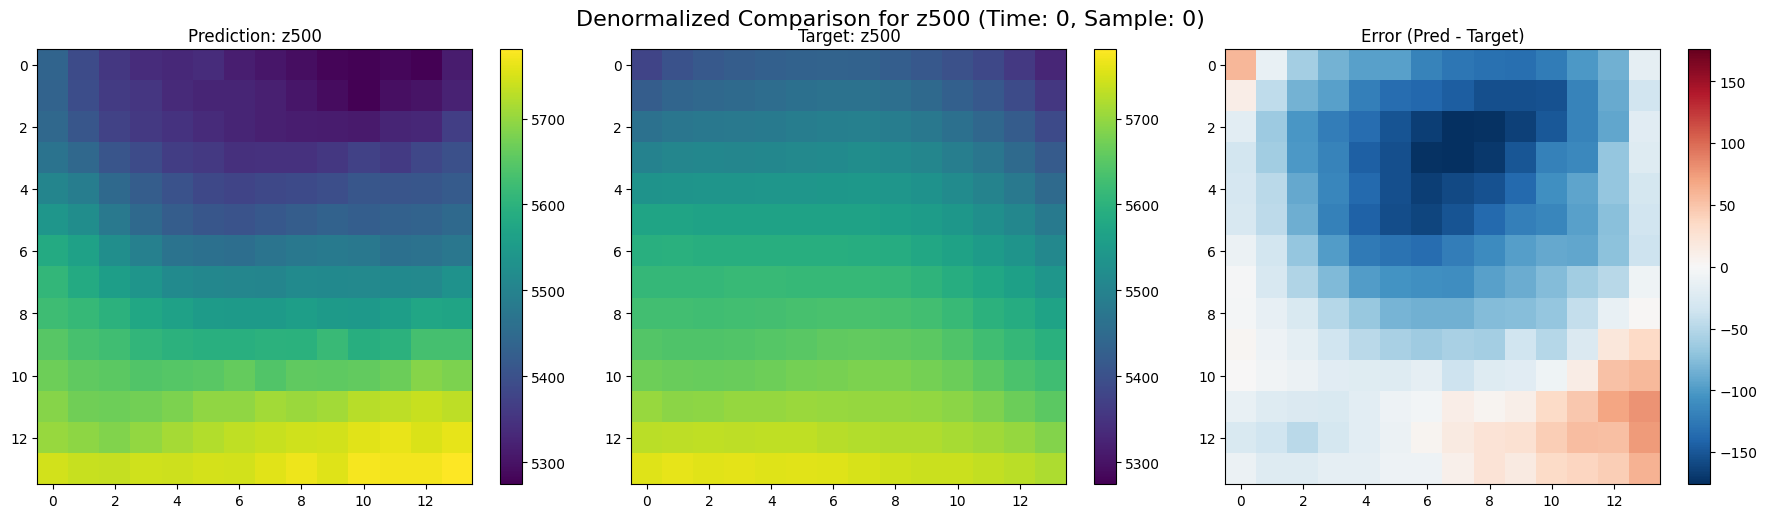

In [33]:
# Load the best model
best_model_path = "/content/drive/MyDrive/Best_models/unet3d_LSTM_15epoch_44days.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Define your variable names (these match your normalization code)
VARIABLE_NAMES = ['z500', 't850', 'e', 'evavt', 'lai_lv', 'pev', 'swvl2', 'swvl3', 't2m', 'tp']

# Run the model on some validation data
with torch.no_grad():
    for batch in val_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = model(inputs)
        break  # Just evaluate one batch for now

# Compute denormalized RMSE
rmse_per_variable, rmse_per_region, denorm_predictions, denorm_targets = compute_denormalized_rmse(
    predictions, targets, VARIABLE_NAMES)

# Visualize the results
visualize_denormalized_predictions(
    denorm_predictions, denorm_targets, VARIABLE_NAMES,
    var_idx=0  # Change this index to visualize different variables
)

In [34]:
overall_rmse = np.mean(rmse_per_variable)  # Mean RMSE across all variables
overall_spatial_rmse = np.mean(rmse_per_region)  # Mean RMSE across all spatial locations
print("Overall Mean RMSE:", overall_rmse)
print("Overall Mean RMSE Across Spatial Locations:", overall_spatial_rmse)

Overall Mean RMSE: 11.673193
Overall Mean RMSE Across Spatial Locations: 31.193684


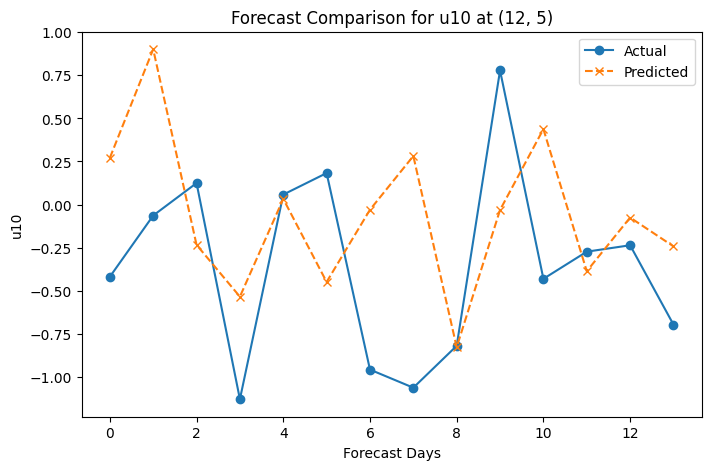

In [ ]:
def plot_forecast_sample(predictions, targets, variable_idx, region_idx):
    """
    Plot a forecast sample for a given variable & spatial location.
    predictions, targets: (B, C, T, H, W)
    variable_idx: Index of the meteorological variable
    region_idx: (lat, lon) grid index
    """
    time_steps = predictions.shape[2]
    pred_series = predictions[0, variable_idx, :, region_idx[0], region_idx[1]].cpu().numpy()
    true_series = targets[0, variable_idx, :, region_idx[0], region_idx[1]].cpu().numpy()

    plt.figure(figsize=(8, 5))
    plt.plot(range(time_steps), true_series, label="Actual", marker="o")
    plt.plot(range(time_steps), pred_series, label="Predicted", marker="x", linestyle="dashed")
    plt.xlabel("Forecast Days")
    plt.ylabel(variable_names[variable_idx])
    plt.title(f"Forecast Comparison for {variable_names[variable_idx]} at {region_idx}")
    plt.legend()
    plt.show()

# Pick a random variable & region
random_variable = np.random.randint(0, 20)
random_region = (np.random.randint(0, 14), np.random.randint(0, 14))  # Latitude, Longitude

# Plot forecast comparison
plot_forecast_sample(predictions, targets, random_variable, random_region)
